In [1]:
# load dataset data/test.csv and data/train.csv

import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)

train.head()

(120000, 2) (7600, 2)


,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar alltime record posing new menac...,2


In [13]:
from bertopic import BERTopic
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"

model = BERTopic(language="english", verbose=True, nr_topics=5, min_topic_size=1000)
topics, probabilities = model.fit_transform(train['text'])

2023-12-04 01:10:08,715 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 3750/3750 [02:09<00:00, 28.96it/s]
2023-12-04 01:12:21,349 - BERTopic - Embedding - Completed ✓
2023-12-04 01:12:21,351 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-04 01:14:07,286 - BERTopic - Dimensionality - Completed ✓
2023-12-04 01:14:07,291 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-04 01:14:55,469 - BERTopic - Cluster - Completed ✓
2023-12-04 01:14:55,471 - BERTopic - Representation - Extracting topics from clusters using representation models.
2023-12-04 01:14:59,318 - BERTopic - Representation - Completed ✓
2023-12-04 01:14:59,320 - BERTopic - Topic reduction - Reducing number of topics
2023-12-04 01:15:03,511 - BERTopic - Topic reduction - Reduced number of topics from 23 to 5


In [14]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,37096,-1_said_new_company_reuters,"[said, new, company, reuters, year, inc, ap, m...",[new nuclear weapon surpass others putin say p...
1,0,29112,0_new_oil_price_reuters,"[new, oil, price, reuters, said, company, stoc...",[stock seen higher job data new york reuters u...
2,1,27967,1_game_ap_win_team,"[game, ap, win, team, first, season, night, vi...",[yankee widen lead jason giambi made first sta...
3,2,15026,2_iraq_said_iraqi_palestinian,"[iraq, said, iraqi, palestinian, baghdad, kill...",[mortar attack iraq kill wound iraqi baghdad i...
4,3,10799,3_ap_bush_space_drug,"[ap, bush, space, drug, kerry, new, reuters, s...",[bush challenge kerry job economy ap ap presid...


In [28]:
# reduce outliers
new_topics = model.reduce_outliers(train.text, topics, strategy="embeddings")

In [24]:
# distribution of new topics, which is a list of integers
pd.Series(new_topics).value_counts()

 0    49276
 1    31011
 2    23153
 3    16554
-1        6
Name: count, dtype: int64

In [30]:
model.visualize_barchart(n_words=10)

In [18]:
import numpy as np
import pandas as pd
from umap import UMAP
 
import matplotlib
import matplotlib.pyplot as plt
 
%matplotlib inline
 
# Prepare data for plotting
embeddings = model._extract_embeddings(train.text, method="document", verbose=True)
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])

Batches: 100%|██████████| 3750/3750 [02:07<00:00, 29.38it/s]


In [21]:
df["topic"] = new_topics

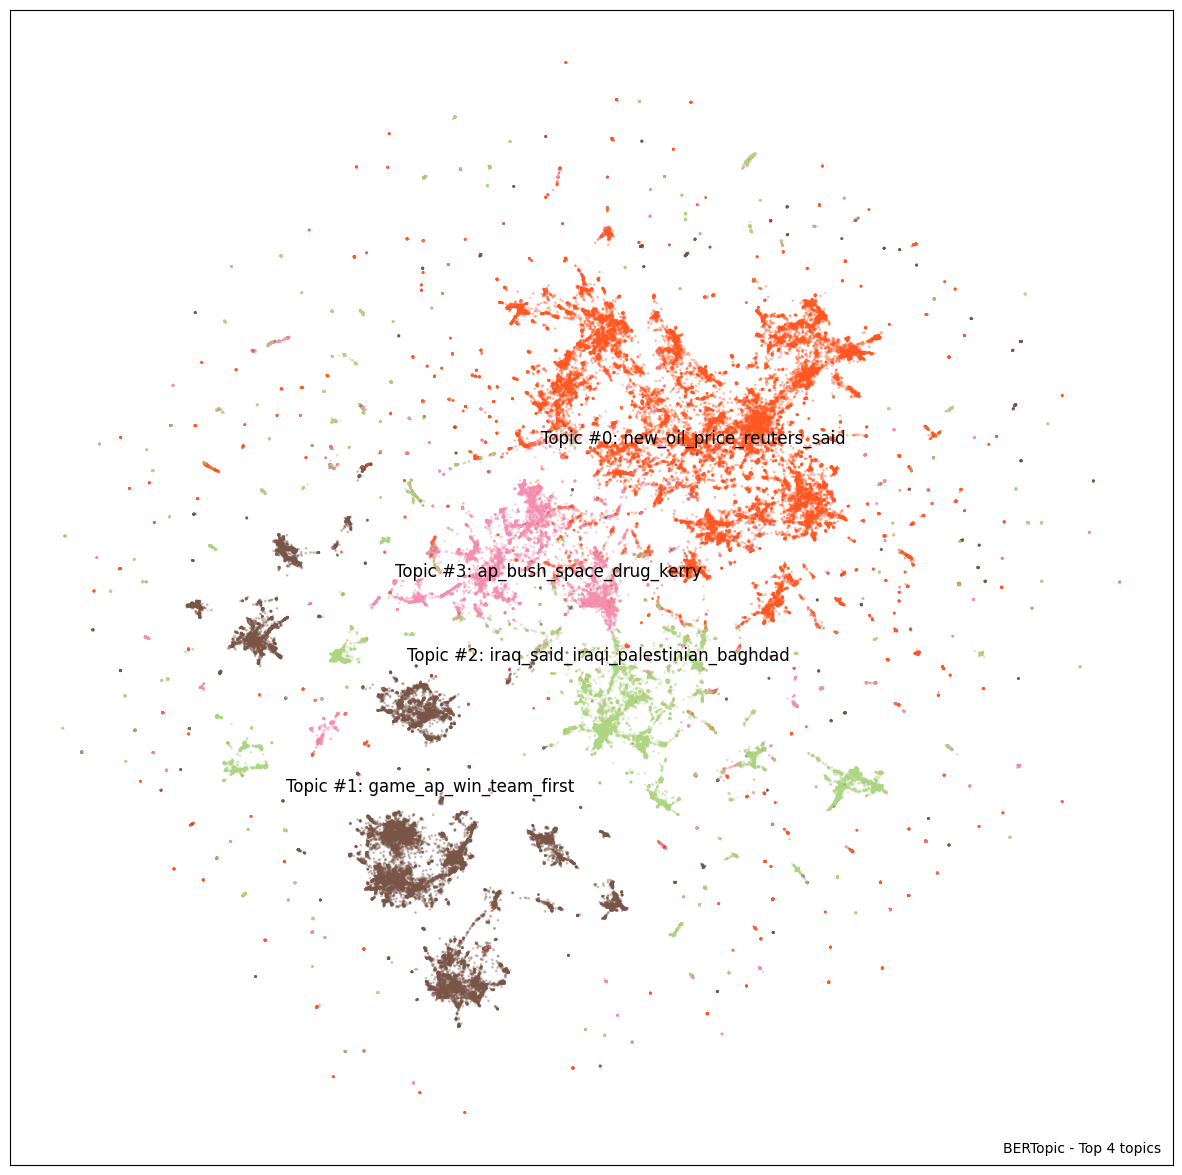

In [31]:
# Plot parameters
top_n = 4
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"Topic #{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:5]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
# plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

In [37]:
# predict topics for test data
test_topics, test_probabilities = model.transform(test['text'])

# reduce outliers
test_topics = model.reduce_outliers(test.text, test_topics, strategy="embeddings")

Batches: 100%|██████████| 238/238 [00:08<00:00, 28.95it/s]
2023-12-04 02:58:30,266 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2023-12-04 02:59:07,092 - BERTopic - Dimensionality - Completed ✓
2023-12-04 02:59:07,094 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2023-12-04 02:59:11,897 - BERTopic - Cluster - Completed ✓


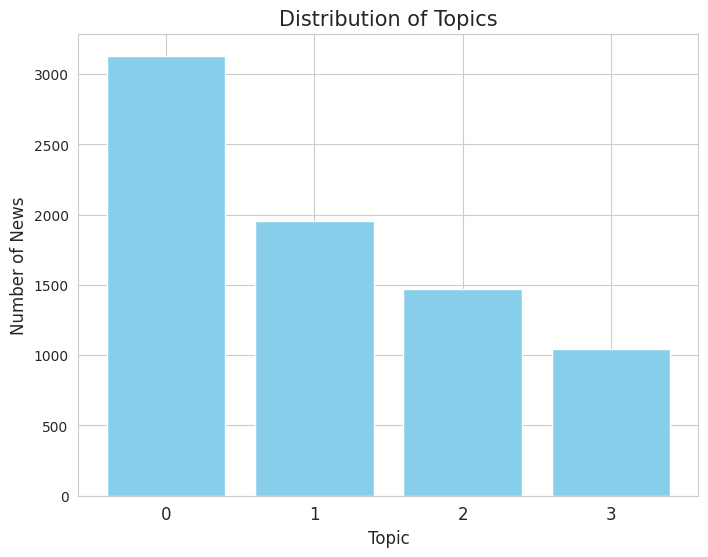

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Count the number of news items per topic
topic_counts = pd.Series(test_topics).value_counts().sort_index()

# remove outliers (topic < 0)
topic_counts = topic_counts[topic_counts.index >= 0]

# Set a style (optional)
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 6))  # Adjust size as needed
plt.bar(topic_counts.index, topic_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of News', fontsize=12)
plt.xticks(topic_counts.index, fontsize=12)
plt.title('Distribution of Topics', fontsize=15)

# Show plot
plt.show()

/tmp/ipykernel_3554534/1139021296.py:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



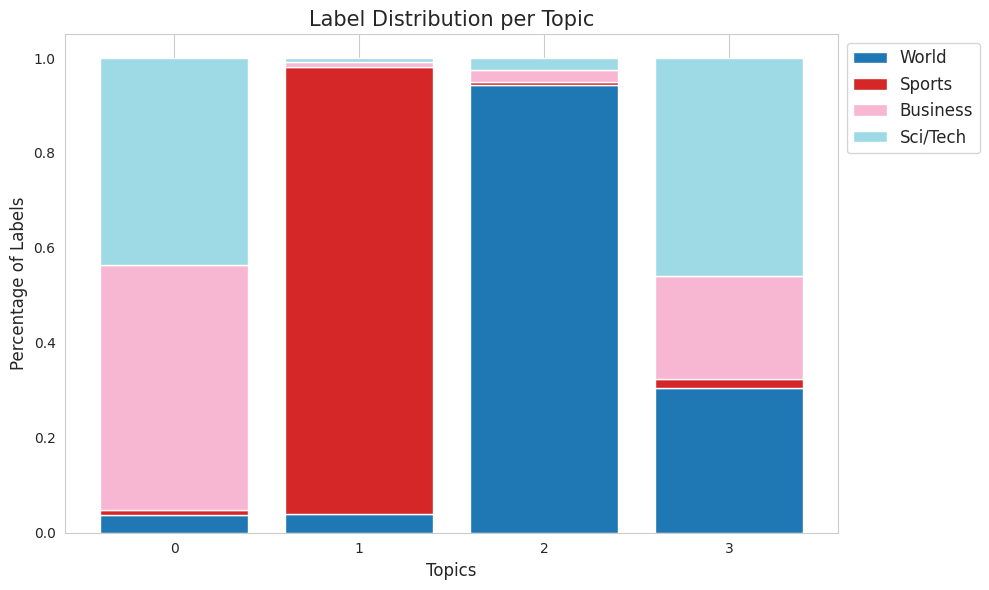

In [40]:
topic_label_count = np.zeros((4, 4))  # Initialize matrix to count labels per topic
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

# Count the labels for each topic
for doc_idx, topic in enumerate(test_topics):
    label = test.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Select a color palette
colors = plt.cm.get_cmap('tab20', 4)  # You can choose other colormaps like 'Set2', 'viridis', etc.

for label in range(4):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(4), topic_label_percentage[:, label], bottom=bottom, color=colors(label), label=label_names[label])

ax.set_xlabel('Topics', fontsize=12)
ax.set_ylabel('Percentage of Labels', fontsize=12)
ax.set_title('Label Distribution per Topic', fontsize=15)
ax.set_xticks(range(4))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
ax.grid(axis='y')  # Add horizontal gridlines

plt.tight_layout()  # Adjust layout to fit everything
plt.show()